## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 

50000/50000 [==============================] - 12s 240us/step - loss: 1.6140 - accuracy: 0.4728 - val_loss: 1.6192 - val_accuracy: 0.4725
Epoch 43/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.6023 - accuracy: 0.4720 - val_loss: 1.6294 - val_accuracy: 0.4645
Epoch 44/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.5992 - accuracy: 0.4721 - val_loss: 1.6245 - val_accuracy: 0.4552
Epoch 45/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.6182 - accuracy: 0.4633 - val_loss: 1.6681 - val_accuracy: 0.4464
Epoch 46/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.6088 - accuracy: 0.4660 - val_loss: 1.6571 - val_accuracy: 0.4501
Epoch 47/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.5823 - accuracy: 0.4770 - val_loss: 1.5847 - val_accuracy: 0.4750
Epoch 48/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.5954 - accuracy: 0.4707 - va

50000/50000 [==============================] - 13s 268us/step - loss: 1.4775 - accuracy: 0.5211 - val_loss: 1.5352 - val_accuracy: 0.4981
Epoch 34/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.4679 - accuracy: 0.5234 - val_loss: 1.4877 - val_accuracy: 0.5171
Epoch 35/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.4693 - accuracy: 0.5233 - val_loss: 1.5405 - val_accuracy: 0.4975
Epoch 36/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.4489 - accuracy: 0.5259 - val_loss: 1.5020 - val_accuracy: 0.5135
Epoch 37/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.4544 - accuracy: 0.5280 - val_loss: 1.5058 - val_accuracy: 0.5101
Epoch 38/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.4524 - accuracy: 0.5274 - val_loss: 1.5015 - val_accuracy: 0.5132
Epoch 39/50
50000/50000 [==============================] - 13s 258us/step - loss: 1.4531 - accuracy: 0.5255 - va

50000/50000 [==============================] - 15s 294us/step - loss: 1.3968 - accuracy: 0.4988 - val_loss: 1.4011 - val_accuracy: 0.4990
Epoch 26/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.3900 - accuracy: 0.4991 - val_loss: 1.4210 - val_accuracy: 0.4926
Epoch 27/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.3753 - accuracy: 0.5057 - val_loss: 1.3733 - val_accuracy: 0.5054
Epoch 28/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.3685 - accuracy: 0.5098 - val_loss: 1.3818 - val_accuracy: 0.5022
Epoch 29/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.3709 - accuracy: 0.5082 - val_loss: 1.4526 - val_accuracy: 0.4895
Epoch 30/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.3508 - accuracy: 0.5177 - val_loss: 1.3579 - val_accuracy: 0.5182
Epoch 31/50
50000/50000 [==============================] - 16s 320us/step - loss: 1.3385 - accuracy: 0.5196 - va

50000/50000 [==============================] - 11s 226us/step - loss: 1.4639 - accuracy: 0.4740 - val_loss: 1.4285 - val_accuracy: 0.4894
Epoch 18/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.4502 - accuracy: 0.4807 - val_loss: 1.4268 - val_accuracy: 0.4854
Epoch 19/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.4433 - accuracy: 0.4810 - val_loss: 1.4034 - val_accuracy: 0.4965
Epoch 20/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.4375 - accuracy: 0.4848 - val_loss: 1.4461 - val_accuracy: 0.4815
Epoch 21/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.4324 - accuracy: 0.4849 - val_loss: 1.4048 - val_accuracy: 0.4945
Epoch 22/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.4186 - accuracy: 0.4917 - val_loss: 1.4141 - val_accuracy: 0.4916
Epoch 23/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.4060 - accuracy: 0.4952 - va

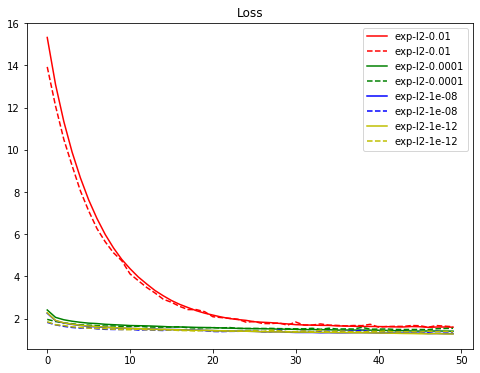

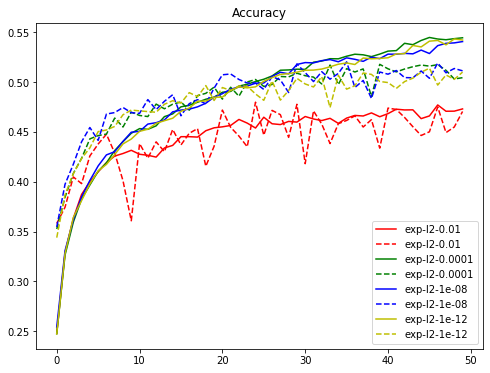

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()